In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary

cudnn.benchmark = True
plt.ion()



Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [3]:
#apple
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


Load Data

In [4]:

data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = '/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/train/good'
train_dataset = CustomDataset(data_dir,data_transforms)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader))

43 11


View Data

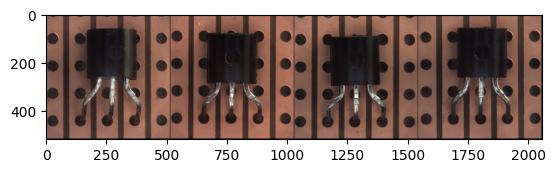

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [6]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [7]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*13*13, 8),
            nn.ReLU(True),
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(8, 256*13*13),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [8]:
testModel = AutoEncoder()
summary(testModel, (3, 512, 512),4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 256, 256]             384
       BatchNorm2d-2           [4, 8, 256, 256]              16
              ReLU-3           [4, 8, 256, 256]               0
            Conv2d-4          [4, 16, 128, 128]           2,048
       BatchNorm2d-5          [4, 16, 128, 128]              32
              ReLU-6          [4, 16, 128, 128]               0
            Conv2d-7            [4, 32, 64, 64]           8,192
       BatchNorm2d-8            [4, 32, 64, 64]              64
              ReLU-9            [4, 32, 64, 64]               0
           Conv2d-10            [4, 64, 32, 32]          32,768
      BatchNorm2d-11            [4, 64, 32, 32]             128
             ReLU-12            [4, 64, 32, 32]               0
           Conv2d-13           [4, 128, 16, 16]         131,072
      BatchNorm2d-14           [4, 128,

Model, Loss & Optimizer

In [9]:
torch.manual_seed(0)

loss = torch.nn.MSELoss()
lr= 0.0001

model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)

model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train

In [10]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [11]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [12]:
def plot_ae_outputs(model,n=10):
  inputs = next(iter(val_dataloader))
  out = torchvision.utils.make_grid(inputs)
  imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training

	 partial train loss (single batch): 0.103195
	 partial train loss (single batch): 0.091673
	 partial train loss (single batch): 0.085680
	 partial train loss (single batch): 0.093274
	 partial train loss (single batch): 0.089925
	 partial train loss (single batch): 0.078375
	 partial train loss (single batch): 0.087100
	 partial train loss (single batch): 0.081695
	 partial train loss (single batch): 0.082174
	 partial train loss (single batch): 0.077921
	 partial train loss (single batch): 0.076876
	 partial train loss (single batch): 0.081666
	 partial train loss (single batch): 0.078563
	 partial train loss (single batch): 0.080750
	 partial train loss (single batch): 0.078759
	 partial train loss (single batch): 0.078813
	 partial train loss (single batch): 0.075790
	 partial train loss (single batch): 0.073135
	 partial train loss (single batch): 0.074833
	 partial train loss (single batch): 0.072564
	 partial train loss (single batch): 0.074375
	 partial train loss (single batch

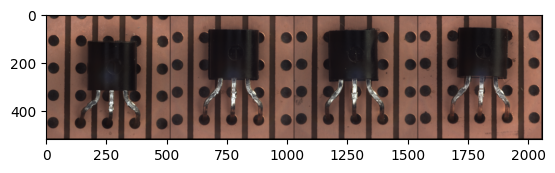

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


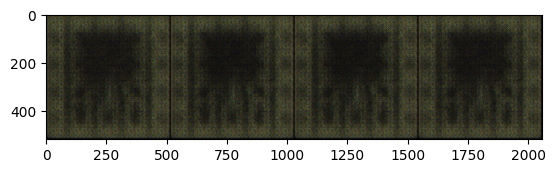

	 partial train loss (single batch): 0.065921
	 partial train loss (single batch): 0.064417
	 partial train loss (single batch): 0.058234
	 partial train loss (single batch): 0.067027
	 partial train loss (single batch): 0.064804
	 partial train loss (single batch): 0.055952
	 partial train loss (single batch): 0.064300
	 partial train loss (single batch): 0.059491
	 partial train loss (single batch): 0.060919
	 partial train loss (single batch): 0.057434
	 partial train loss (single batch): 0.056282
	 partial train loss (single batch): 0.061194
	 partial train loss (single batch): 0.059479
	 partial train loss (single batch): 0.060997
	 partial train loss (single batch): 0.059099
	 partial train loss (single batch): 0.059423
	 partial train loss (single batch): 0.056674
	 partial train loss (single batch): 0.055472
	 partial train loss (single batch): 0.056270
	 partial train loss (single batch): 0.054630
	 partial train loss (single batch): 0.056163
	 partial train loss (single batch

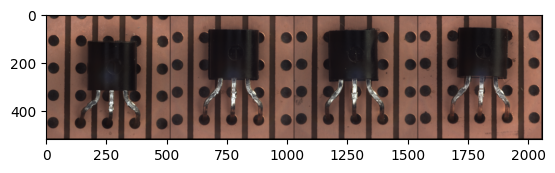

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


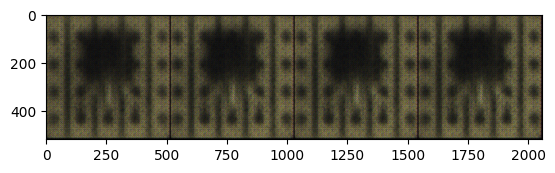

	 partial train loss (single batch): 0.050020
	 partial train loss (single batch): 0.046259
	 partial train loss (single batch): 0.044496
	 partial train loss (single batch): 0.050798
	 partial train loss (single batch): 0.049184
	 partial train loss (single batch): 0.042125
	 partial train loss (single batch): 0.049473
	 partial train loss (single batch): 0.045130
	 partial train loss (single batch): 0.046950
	 partial train loss (single batch): 0.044228
	 partial train loss (single batch): 0.042954
	 partial train loss (single batch): 0.047223
	 partial train loss (single batch): 0.046581
	 partial train loss (single batch): 0.047353
	 partial train loss (single batch): 0.045555
	 partial train loss (single batch): 0.045815
	 partial train loss (single batch): 0.043515
	 partial train loss (single batch): 0.043269
	 partial train loss (single batch): 0.043382
	 partial train loss (single batch): 0.042225
	 partial train loss (single batch): 0.043664
	 partial train loss (single batch

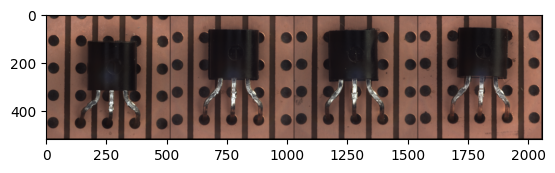

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


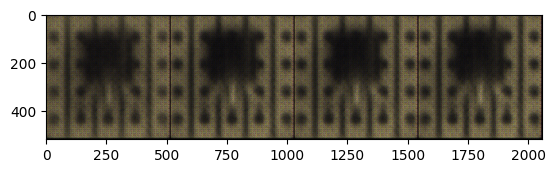

	 partial train loss (single batch): 0.039450
	 partial train loss (single batch): 0.036395
	 partial train loss (single batch): 0.035362
	 partial train loss (single batch): 0.040194
	 partial train loss (single batch): 0.038611
	 partial train loss (single batch): 0.033055
	 partial train loss (single batch): 0.039440
	 partial train loss (single batch): 0.035356
	 partial train loss (single batch): 0.037349
	 partial train loss (single batch): 0.035040
	 partial train loss (single batch): 0.033660
	 partial train loss (single batch): 0.037368
	 partial train loss (single batch): 0.037267
	 partial train loss (single batch): 0.037348
	 partial train loss (single batch): 0.035707
	 partial train loss (single batch): 0.035895
	 partial train loss (single batch): 0.033873
	 partial train loss (single batch): 0.034201
	 partial train loss (single batch): 0.033854
	 partial train loss (single batch): 0.032894
	 partial train loss (single batch): 0.034140
	 partial train loss (single batch

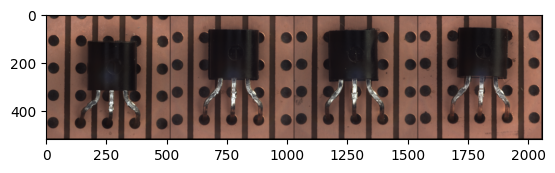

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


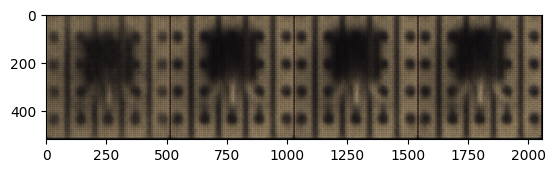

	 partial train loss (single batch): 0.030657
	 partial train loss (single batch): 0.028316
	 partial train loss (single batch): 0.027986
	 partial train loss (single batch): 0.031543
	 partial train loss (single batch): 0.030132
	 partial train loss (single batch): 0.025766
	 partial train loss (single batch): 0.031425
	 partial train loss (single batch): 0.027611
	 partial train loss (single batch): 0.029616
	 partial train loss (single batch): 0.027847
	 partial train loss (single batch): 0.026542
	 partial train loss (single batch): 0.029694
	 partial train loss (single batch): 0.029646
	 partial train loss (single batch): 0.029678
	 partial train loss (single batch): 0.028140
	 partial train loss (single batch): 0.028371
	 partial train loss (single batch): 0.026640
	 partial train loss (single batch): 0.027309
	 partial train loss (single batch): 0.026739
	 partial train loss (single batch): 0.025964
	 partial train loss (single batch): 0.026897
	 partial train loss (single batch

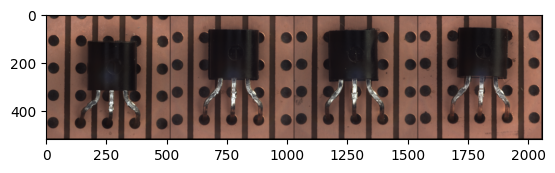

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


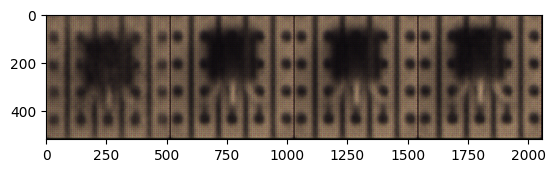

In [13]:
num_epochs = 5
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Temp Section do not delete

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 512, 512])


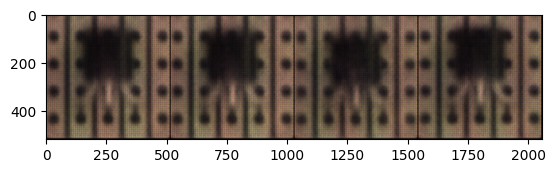

In [14]:
inputs = next(iter(train_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

In [15]:
with torch.no_grad():
        conc_out = []
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            conc_out.append(decoded_data.cpu())
        conc_out = torch.cat(conc_out)
print(conc_out)

tensor([[ 0.0000,  0.0000,  0.0000,  8.4251,  0.0000,  3.4619,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  8.2559,  0.0000, 10.5381,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  8.4424,  0.0000, 10.8333,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  7.8440,  0.0000, 13.4099,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  8.6865,  0.0000,  6.8672,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  6.9580,  0.0000, 10.6448,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  5.2434,  0.0000, 12.6136,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  9.4322,  0.0000,  3.5862,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  8.3282,  0.0000,  8.6254,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  5.6263,  0.0000,  8.2775,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 10.7807,  0.0000,  8.4905,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  9.6420,  0.0000,  9.2002,  0.0000,  0.0000],
        [ 0.0000